## Importing necessary packages

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

# Classifiers
from sklearn.dummy import DummyClassifier

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier

In [17]:
# Shutting down the warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Reading data and EDA

In [4]:
claim_df = pd.read_csv("PartII_Data/ClaimData.csv")

In [6]:
claim_df.head()

,ClaimId,LineItemID,PetPolicyID,ItemDescription,DiagnosisOne,DiagnosisTwo,LineItemPrice,ClaimDateClosed,Condition
0,16980751,2073120,0,Freyja: Boarding (Canine 51-75 Lbs),Anal Gland Surgery,NaN,25.00,2019-10-02 15:33:00.0000000,NO COND
1,17856529,3193005,1,Axel: Biohazard Fee,Atopy,NaN,3.49,2020-06-29 14:28:00.0000000,ALLERGY (ALLERGIC)
2,17075791,392218,3,Kallie: Sedation (DexDomitor),ruptured CCL (right),NaN,142.22,2019-11-01 19:29:00.0000000,"CRUCIATE RUPTURE (ACL, CCL)"
3,16890631,977795,4,Kaiden: Scaling (Canine),Dental,NaN,84.25,2019-09-05 13:57:00.0000000,DENTAL DISEASE
4,17152945,1907072,5,Sadie Mae: Pain Management Level 2,TPLO,NaN,67.60,2019-11-26 07:43:00.0000000,"CRUCIATE RUPTURE (ACL, CCL)"


In [7]:
claim_df.columns= claim_df.columns.str.lower()

In [8]:
print(claim_df.info())
print('------------------------------')
print(claim_df.describe())
print('------------------------------')
print(claim_df["condition"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98057 entries, 0 to 98056
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   claimid          98057 non-null  int64  
 1   lineitemid       98057 non-null  int64  
 2   petpolicyid      98057 non-null  int64  
 3   itemdescription  98057 non-null  object 
 4   diagnosisone     98048 non-null  object 
 5   diagnosistwo     5077 non-null   object 
 6   lineitemprice    98057 non-null  float64
 7   claimdateclosed  98057 non-null  object 
 8   condition        98057 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.7+ MB
None
------------------------------
            claimid    lineitemid   petpolicyid  lineitemprice
count  9.805700e+04  9.805700e+04  98057.000000   98057.000000
mean   1.652385e+07  1.906811e+06  28423.080351      83.275086
std    1.561986e+06  1.119586e+06  19225.149658     158.138538
min    1.301355e+07  2.000000e+00   

In [42]:
claim_df.isna().sum()

claimid            0
lineitemid         0
petpolicyid        0
itemdescription    0
diagnosisone       0
diagnosistwo       0
lineitemprice      0
condition          0
dtype: int64

In [10]:
claim_df[['diagnosisone', 'diagnosistwo']] = claim_df[['diagnosisone', 'diagnosistwo']].fillna('none')

In [11]:
claim_df[claim_df.duplicated(subset = None, keep = False)]

,claimid,lineitemid,petpolicyid,itemdescription,diagnosisone,diagnosistwo,lineitemprice,claimdateclosed,condition


### Droping `claimdateclosed` column 
#### It does not have impact on our modeling.

In [12]:
claim_df = claim_df.drop(columns = ['claimdateclosed'])

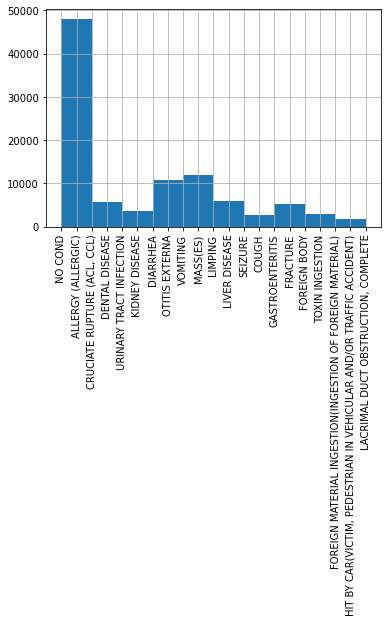

In [13]:
claim_df.condition.hist()
plt.xticks(rotation='vertical');

## Observations:
#### - There are 21 classes in the `condition` column;
#### - Except three main features of `itemdescription`, `diagnosisone`, and `diagnosistwo` the othere featurs are id's;
#### - `diagnosistwo` only has 5077 non_null data out of 98057, so it is not considered for the preliminary analysis; 
#### - To simplify the data and create a simple preliminary model, `diagnosisone` is considered as the input feature;

## Creating X_train and y_train

In [14]:
### Separating X_train and y_train
X_train = claim_df.drop(columns=['condition'])
y_train = claim_df['condition']

### Function for storing the mean and standard deviation of the scores of the models

In [15]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, 
                            X_train, y_train, 
                            **kwargs)    
    
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):  
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data = out_col, index = mean_scores.index)    

In [36]:
results = {}
scoring_metric = 'accuracy'

### Using Dummy Classifier model to create the baseline

In [37]:
dummy_pipe = make_pipeline(CountVectorizer(), DummyClassifier(strategy='stratified'))

In [38]:
results['Dummy'] = mean_std_cross_val_scores(dummy_pipe, X_train['diagnosisone'], y_train, return_train_score=True, scoring=scoring_metric)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


### The models used include:

#### - Logistic Regression
#### - Decision Tree
#### - Random Forest
#### - XGBoost
#### - LGBMClassifier
#### - CatBoostClassifier
#### - SVC

In [39]:
pipe_lr = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=2000, random_state=123))
pipe_dt = make_pipeline(CountVectorizer(), DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(CountVectorizer(), XGBClassifier(random_state=123))
pipe_lgbm = make_pipeline(CountVectorizer(), LGBMClassifier(random_state=123))
pipe_catboost = make_pipeline(CountVectorizer(), CatBoostClassifier(verbose=0, random_state=123))
classifiers = {
    'logistic regression' : pipe_lr,
    'decision tree' : pipe_dt,
    'random forest' : pipe_rf,
    'XGBoost' : pipe_xgb, 
    'LightGBM' : pipe_lgbm,
    'CatBoost' : pipe_catboost
}

In [40]:
for (name, model) in classifiers.items():    
    results[name] = mean_std_cross_val_scores(model,X_train['diagnosisone'], y_train , return_train_score=True, scoring=scoring_metric)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following:

[08:58:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:18:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:18:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:19:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:20:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator

In [43]:
pd.DataFrame(results)

,Dummy,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost
fit_time,0.375 (+/- 0.006),34.476 (+/- 2.604),7.311 (+/- 0.054),198.645 (+/- 3.475),258.473 (+/- 520.547),0.416 (+/- 0.008),876.684 (+/- 76.100)
score_time,0.110 (+/- 0.006),0.133 (+/- 0.007),0.126 (+/- 0.002),2.144 (+/- 0.114),0.748 (+/- 0.056),0.000 (+/- 0.000),0.182 (+/- 0.009)
test_score,0.192 (+/- 0.002),0.663 (+/- 0.002),0.647 (+/- 0.005),0.665 (+/- 0.003),0.662 (+/- 0.001),nan (+/- nan),0.651 (+/- 0.002)
train_score,0.192 (+/- 0.001),0.710 (+/- 0.001),0.821 (+/- 0.000),0.821 (+/- 0.000),0.699 (+/- 0.000),nan (+/- nan),0.659 (+/- 0.001)


### Observations so far:

#### - Random Forest and decision tree models are overfitting;
#### - Logistic Regression has a fairly short fit time and train_score and validation_score are close;
#### - Cat Boost is the best for its scores on train_score and validation_score and small standard devitions but it takes too long to fit and short time to score;
#### - Among all models XGBoost has fairly close train_score and validation_score and a reasonable time to fit but a long time to score;

### Overall result so far:
#### -- Cat Boost and XGBoost are very similar for the time they take to fit and score; 
#### -- Cat Boost have a very close test score and train score so we choose Cat Boost if the long time of training and scoring is not important for us;
#### -- If the time is improtant then we choose Logistic Regression;

#### -- It should be noted that these results are based on default hyperparameters; 
#### -- Hyperparameter optimization can be carried out for all of them and then compare the results;

#### `CountVectorizer` is the simplest way of extracting features from text. As the next step `Tfidfvectorizer` is a statistical method that measures how relevant a word is to a document in a set of documents. As the next step `Tfidfvectorizer` is used for the feature extraction in two models `LogisticRegression` and `SCV`

In [53]:
pipe_tfidf_lr = make_pipeline(TfidfVectorizer( stop_words='english'), LogisticRegression(max_iter=2000, random_state=123))

In [54]:
pipe_tfidf_lr.fit(X_train['diagnosisone'], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=123))])

In [56]:
results['logistc regression tfidf'] = mean_std_cross_val_scores(pipe_tfidf_lr,X_train['diagnosisone'], y_train , return_train_score=True, scoring=scoring_metric)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
pipe_tfidf_svc = make_pipeline(TfidfVectorizer( stop_words='english'), svc)

In [ ]:
pipe_tfidf_svc.fit(X_train['diagnosisone'], y_train)

In [ ]:
results['svc tfidf'] = mean_std_cross_val_scores(pipe_tfidf_svc,X_train['diagnosisone'], y_train , return_train_score=True, scoring=scoring_metric)

In [62]:
pd.DataFrame(results)

,Dummy,logistic regression,decision tree,random forest,XGBoost,LightGBM,CatBoost,logistc regression tfidf,svc tfidf
fit_time,0.375 (+/- 0.006),34.476 (+/- 2.604),7.311 (+/- 0.054),198.645 (+/- 3.475),258.473 (+/- 520.547),0.416 (+/- 0.008),876.684 (+/- 76.100),31.894 (+/- 2.398),531.521 (+/- 232.185)
score_time,0.110 (+/- 0.006),0.133 (+/- 0.007),0.126 (+/- 0.002),2.144 (+/- 0.114),0.748 (+/- 0.056),0.000 (+/- 0.000),0.182 (+/- 0.009),0.142 (+/- 0.011),431.703 (+/- 825.876)
test_score,0.192 (+/- 0.002),0.663 (+/- 0.002),0.647 (+/- 0.005),0.665 (+/- 0.003),0.662 (+/- 0.001),nan (+/- nan),0.651 (+/- 0.002),0.651 (+/- 0.002),0.671 (+/- 0.002)
train_score,0.192 (+/- 0.001),0.710 (+/- 0.001),0.821 (+/- 0.000),0.821 (+/- 0.000),0.699 (+/- 0.000),nan (+/- nan),0.659 (+/- 0.001),0.676 (+/- 0.001),0.750 (+/- 0.000)


### Logistic regression with tfidf has a very similar result to CatBoost with much less fit time.
## Logistic Regression with tfidf is used as the best model.
### As the next step hyperparameter optimizaition is carried out on hyperparmeter C for Logistic Regression.

In [66]:
### Writing a loop for hyperparameter optimization for C for Logistic Regression
param_grid = {
    "C": [0.1, 1.0, 10, 100]
}

param_scores = { "C": [], "train_accuracy": [], "valid_accuracy": []}

for c_val in param_grid["C"]:
    pipe = make_pipeline(TfidfVectorizer( stop_words='english'), LogisticRegression(max_iter=2000, random_state=123, C=c_val))
    scores = cross_validate(pipe, X_train['diagnosisone'], y_train, cv=5, return_train_score=True)
    param_scores["C"].append(c_val)
    param_scores["train_accuracy"].append(np.mean(scores["train_score"]))
    param_scores["valid_accuracy"].append(np.mean(scores["test_score"]))

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

In [67]:
pd.DataFrame(param_scores).sort_values('valid_accuracy', ascending=False)

,C,train_accuracy,valid_accuracy
2,10.0,0.730465,0.658872
1,1.0,0.675531,0.651407
3,100.0,0.740936,0.650632
0,0.1,0.624315,0.621180


### The two choices here are:
  #### - Using Logistic Regression with the highest validation score (C= 10.0);
  #### - Using Logistic Regression with the closest train_accuracy and valid_accuracy (C=1.0)
    
    

# Final solution: Using Logistic Regression with C=10.0 on test set

### Reading Test Data

In [69]:
test_df = pd.read_csv("PartII_Data/Holdout.csv")

In [70]:
# Inspecting the test_df for missing data
test_df.isna().sum()

ClaimId               0
LineItemID            0
PetPolicyID           0
ItemDescription       0
DiagnosisOne          1
DiagnosisTwo       4841
LineItemPrice         0
ClaimDateClosed       0
Condition          5000
dtype: int64

In [71]:
test_df['DiagnosisOne'] = test_df['DiagnosisOne'].fillna("None")

In [74]:
pipe_lr_tfidf_hyp_c_10 = make_pipeline(TfidfVectorizer( stop_words='english'), LogisticRegression(max_iter=2000, random_state=123, C=10))

In [75]:
pipe_lr_tfidf_hyp_c_10.fit(X_train['diagnosisone'], y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=2000, random_state=123))])

In [76]:
predictions = pipe_lr_tfidf_hyp_c_10.predict(test_df['DiagnosisOne'])

In [77]:
predictions[:10]

array(['NO COND', 'NO COND', 'NO COND', 'MASS(ES)', 'NO COND',
       'ALLERGY (ALLERGIC)', 'NO COND', 'NO COND', 'OTITIS EXTERNA',
       'NO COND'], dtype=object)

In [78]:
prediction_df = pd.DataFrame(predictions, columns = ['pred'])
prediction_df.to_csv('condition_prediction.csv')

### Next steps to improve the results:
- Adding the `itemdescription` feature; 
- Using Averaging or Stacking to get the best of all models together;